# 2. 데이터 전처리

## 2-1. 데이터 로드 및 연결

In [1]:
import numpy as np
import os

# GPU가 없는 시스템에서는 자동으로 CPU 모드로 실행됨.

# CUDA_VISIBLE_DEVICES 환경 변수를 설정하여 사용 가능한 GPU를 지정
# '1'번 GPU를 사용하도록 설정 (0번부터 시작하여 번호가 매겨짐)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# TF_FORCE_GPU_ALLOW_GROWTH 환경 변수를 설정하여 TensorFlow가 GPU 메모리를 동적으로 사용할 수 있게 함
# 기본적으로 TensorFlow는 모든 GPU 메모리를 할당하지만, 이 설정을 통해 필요한 만큼만 할당하게 함
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# 인식할 동작 목록 정의
actions = [
    'one',
    'two',
    'three',
    'four',
    'five',
    'good',
    'bad'
]

# 각 동작에 해당하는 데이터를 로드하여 하나의 배열로 연결
data = np.concatenate([
    np.load('dataset/seq_one_1718555953.npy'),
    np.load('dataset/seq_two_1718555953.npy'),
    np.load('dataset/seq_three_1718555953.npy'),
    np.load('dataset/seq_four_1718555953.npy'),
    np.load('dataset/seq_five_1718555953.npy'),
    np.load('dataset/seq_good_1718555953.npy'),
    np.load('dataset/seq_bad_1718555953.npy')
], axis=0) # 첫 번째 축(axis=0)을 따라 데이터를 연결

# 연결된 데이터의 형태 출력
data.shape # 예를 들어, (900, 30, 68)처럼 연결된 데이터의 차원 정보를 출력

(6050, 30, 100)

(6079, 30, 100)

전체 데이터 셋에 6079의 개별 시퀀스가 있음

각 시퀀스는 30개의 시간 단계(timesteps)로 구성되어 있음

각 시간 단계에는 100개의 피처(feature)가 있음


7가지 손동작을 합쳐서 총 6097번 촬영이 이루어졌다. 

손동작마다 촬영된 횟수가 균등하지 않을 수 있다.


## 2-2. 데이터 분리


### 입력 데이터와 라벨 분리


In [3]:
# 데이터에서 입력 데이터(x_data)와 라벨(labels) 분리
# x_data는 마지막 축을 제외한 모든 데이터를 포함
# labels는 마지막 축의 첫 번째 값을 사용하여 각 시퀀스의 라벨로 설정
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

# 분리된 데이터의 형태 출력
print(x_data.shape)   # 예를 들어, (900, 30, 67)
print(labels.shape)   # 예를 들어, (900,)

(6050, 30, 99)
(6050,)


입력 데이터 (x_data) : 모델에 입력으로 들어감, 여러 피처(특징)을 포함하고 있음. 모델이 학습을 통해 패턴을 인식하고 예측할 수 있도록 해줌. 마지막 축을 제외한 모든 데이터를 포함

    
라벨 (labels) : 각 입력 데이터에 대한 정답(타깃). 모델이 예측한 값과 비교하려 학습 성능을 평가하는 기준이 됨. 마지막 축의 첫 번째 값을 사용하여 각 시퀀스의 라벨로 설정
    

### 라벨 원-핫 인코딩

In [4]:
# TensorFlow Keras의 to_categorical을 사용하여 라벨을 원-핫 인코딩
from tensorflow.keras.utils import to_categorical

# 원-핫 인코딩된 라벨 데이터 생성
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape  # 예를 들어, (900, 3)

#(6079, 7) 여기서 7은 클래스의 수 

(6050, 7)

원-핫 인코딩 : 각 라벨을 이진 벡터로 변환하는 과정. 모델이 각 클래스에 대한 확률을 출력할 수 있도록 함.
    
    예를들어) 7개의 클래스가 있을 때, 라벨2는 [0, 0, 1, 0, 0, 0, 0]로 변환됨
    
    
타겟 데이터 (y_data) : 모델이 예측하려는 값. 예를들어 이미지에 해당하는 라벨 (one, two, three 등)

위의 코드에서는 x_data와 labels 데이터로 나눈 후, labels 데이터를 원-핫 인코딩을 해서 y_data로 생성했음

x_data : 독립변수 : 모델의 학습과 예측에 사용됨

y_data : 종속변수 : 모델의 성능 평가와 학습 과정에서의 오류 계산에 사용됨

## 2-3. 데이터셋 분할

In [5]:
# sklearn의 train_test_split을 사용하여 데이터셋을 학습 데이터와 검증 데이터로 분할
from sklearn.model_selection import train_test_split

# 데이터 타입을 float32로 변환
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

# 학습 데이터와 검증 데이터로 분할 (10%는 검증 데이터로 사용)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

# train : 학습용
# val : 검증용

# 분할된 데이터셋의 형태 출력
print(x_train.shape, y_train.shape)  # 예를 들어, (810, 30, 67) (810, 3) #샘플수, 각 샘플의 시간단계 수, 각 시간 단계에서의 피처 수 / 샘플수, 출력 값 차원
print(x_val.shape, y_val.shape)      # 예를 들어, (90, 30, 67) (90, 3)

(5445, 30, 99) (5445, 7)
(605, 30, 99) (605, 7)


1. 데이터 타입 변환 : 

x_data와 y_data를 float32타입으로 변환 : float64 보다 더 적은 메모리를 사용. Tenserflow와 같은 딥러닝 프레임워크는 주로 float32 타입을 사용함. 이는 주로 메모리 사용을 최적화하고, 특정 딥러닝 프레임워크에서 요구하는 데이터 타입을 맞추기 위함임
 
 
2. 데이터셋 분할 : 

sklearn.model_selection 모듈의 train_test_split 함수를 사용하여 데이터를 학습 데이터와 검증 데이터로 분할함.
전체 데이터의 10%는 검증 데이터로 사용됨.


# 3. 모델 구축 및 컴파일

텐서플로우 케라스를 사용하여 시계열 데이터를 처리하는 lstm 모델의 정의하고 학습시킴

케라스의 순차모델 (sequential) 을 사용하여 레이어를 순차적으로 쌓아올림.


안녕하세요, 오늘 저는 TensorFlow와 Keras를 사용하여 LSTM 기반의 딥러닝 모델을 구축하고 학습시키는 방법에 대해 설명드리겠습니다. 이 코드의 각 부분을 차근차근 살펴보면서, 모델의 구축부터 학습까지의 전체 과정을 이해해보도록 하겠습니다.

# 1 모델 정의 

먼저, Sequential 모델을 정의합니다. Sequential 모델은 레이어를 순차적으로 쌓아올리는 방식입니다.

python




LSTM 레이어


첫 번째 레이어는 LSTM (Long Short-Term Memory) 레이어입니다. LSTM은 순환 신경망(RNN)의 일종으로, 시간에 따른 데이터의 패턴을 학습하는 데 유용합니다. 이 레이어는 64개의 유닛을 가지고 있으며, 활성화 함수로는 ReLU를 사용합니다. 입력 형태는 (시퀀스 길이, 피처 수)로 설정되어 있습니다.


Dense 레이어


두 번째 레이어는 Dense 레이어로, 32개의 유닛과 ReLU 활성화 함수를 사용합니다.
마지막 레이어는 출력 레이어로, 인식할 동작의 수만큼의 유닛을 가지고 있으며, 소프트맥스 활성화 함수를 사용하여 다중 클래스 분류를 수행합니다.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 모델을 Sequential 형태로 정의
model = Sequential([
    # 첫 번째 LSTM 레이어
    # 유닛 수: 64, 활성화 함수: ReLU, 입력 형태: (시퀀스 길이, 피처 수)
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    # 두 번째 Dense 레이어
    # 유닛 수: 32, 활성화 함수: ReLU
    Dense(32, activation='relu'),
    # 세 번째 Dense 레이어 (출력 레이어)
    # 유닛 수: 인식할 동작의 수, 활성화 함수: 소프트맥스
    Dense(len(actions), activation='softmax')
])

C:\Users\by130\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 2 모델 컴파일 및 요약



옵티마이저(Optimizer):

옵티마이저는 모델의 학습 과정을 조절하는 알고리즘입니다.
Adam 옵티마이저는 경사 하강법을 기반으로 하는 알고리즘으로, 학습 속도를 조절하는 데 효과적입니다.

손실 함수 (Loss Function):

손실 함수는 모델의 예측값과 실제 값 간의 차이를 측정하는 함수입니다.
손실 함수로는 categorical_crossentropy를 사용합니다. 이는 다중 클래스 분류 문제에서 주로 사용되는 손실 함수입니다.

평가 메트릭(Metrics):

메트릭은 모델의 성능을 평가하기 위한 지표입니다.
평가 메트릭으로는 정확도(acc)를 사용합니다. 이는 모델의 성능을 평가하는 데 사용됩니다.

In [7]:

# 모델 컴파일
# 옵티마이저: Adam, 손실 함수: categorical_crossentropy, 메트릭: 정확도(acc)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# 모델 요약 출력
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          41,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,295 (173.03 KB)

 Trainable params: 44,295 (173.03 KB)

 Non-trainable params: 0 (0.00 B)

## 4 모델 학습

이제 모델을 학습시킵니다. 학습 단계에서는 학습 데이터, 검증 데이터, 에포크 수, 그리고 콜백 함수들을 설정합니다.


ModelCheckpoint 콜백

ModelCheckpoint 콜백은 학습 과정 중 최상의 성능을 보이는 모델을 저장합니다. 여기서는 검증 정확도를 모니터링하고, 최상의 검증 정확도를 기록한 모델만 저장하도록 설정합니다.

ReduceLROnPlateau 콜백

ReduceLROnPlateau 콜백은 학습 속도를 동적으로 조정합니다. 검증 정확도가 50 에포크 동안 개선되지 않으면 학습 속도를 50%로 줄입니다. 이는 모델이 더 좋은 최적화 지점을 찾도록 도와줍니다.

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# 모델 학습
history = model.fit(
    x_train,              # 학습 데이터
    y_train,              # 학습 라벨
    validation_data=(x_val, y_val),  # 검증 데이터 및 라벨
    epochs=200,           # 총 학습 에포크 수
    callbacks=[
        # ModelCheckpoint 콜백: 최적의 모델을 저장
        ModelCheckpoint(
            'models/model.keras',  # 모델 파일 저장 경로
            monitor='val_acc',         # 검증 정확도를 모니터링
            verbose=1,                 # 저장 시 메시지 출력
            save_best_only=True,       # 최상의 검증 정확도를 가진 모델만 저장
            mode='auto'                # 최적화 기준 모드 자동 설정
        ),
        # ReduceLROnPlateau 콜백: 학습 속도 조정
        ReduceLROnPlateau(
            monitor='val_acc',         # 검증 정확도를 모니터링
            factor=0.5,                # 학습 속도를 줄이는 비율
            patience=50,               # 50 에포크 동안 개선이 없으면 학습 속도를 줄임
            verbose=1,                 # 학습 속도 조정 시 메시지 출력
            mode='auto'                # 최적화 기준 모드 자동 설정
        )
    ]
)


Epoch 1/200
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9378 - loss: 0.1684
Epoch 1: val_acc improved from -inf to 0.93223, saving model to models/model.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.9378 - loss: 0.1683 - val_acc: 0.9322 - val_loss: 0.2046 - learning_rate: 0.0010
Epoch 2/200
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9467 - loss: 0.1418
Epoch 2: val_acc improved from 0.93223 to 0.94050, saving model to models/model.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.9466 - loss: 0.1420 - val_acc: 0.9405 - val_loss: 0.1932 - learning_rate: 0.0010
Epoch 3/200
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7907 - loss: 12.9543
Epoch 3: val_acc did not improve from 0.94050
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.7830 - loss: 13.7637 - val_acc: 0.3256 - val_loss: 5.4937 - learning_rate: 0.0010
Epoch 4/200
164/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.3417 - loss: 25.6096
Epoch 4: val_acc did not improve from 0.94050
171/171 ━━━━━

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9549 - loss: 0.1932
Epoch 25: val_acc did not improve from 0.96529
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9549 - loss: 0.1931 - val_acc: 0.9653 - val_loss: 0.1025 - learning_rate: 0.0010
Epoch 26/200
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9629 - loss: 0.1645
Epoch 26: val_acc improved from 0.96529 to 0.97355, saving model to models/model.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9628 - loss: 0.1643 - val_acc: 0.9736 - val_loss: 0.0808 - learning_rate: 0.0010
Epoch 27/200
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9684 - loss: 0.1250
Epoch 27: val_acc did not improve from 0.97355
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9683 - loss: 0.1254 - val_acc: 0.9504 - val_loss: 0.2472 - learning_rate: 0.0010
Epoch 28/200
162/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9628 - loss: 0.1502
Epoch 28: val_acc did not improve from 0.97355
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9630 - los

Epoch 50/200
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9947 - loss: 0.0166
Epoch 50: val_acc did not improve from 0.99835
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9947 - loss: 0.0166 - val_acc: 0.9537 - val_loss: 0.1201 - learning_rate: 0.0010
Epoch 51/200
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9851 - loss: 0.0420
Epoch 51: val_acc did not improve from 0.99835
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9852 - loss: 0.0419 - val_acc: 0.9967 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 52/200
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9952 - loss: 0.0153
Epoch 52: val_acc improved from 0.99835 to 1.00000, saving model to models/model.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9952 - loss: 0.0153 - val_acc: 1.0000 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 53/200
164/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9976 - loss: 0.0129
Epoch 53: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc:

Epoch 75/200
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9822 - loss: 0.0671
Epoch 75: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.9822 - loss: 0.0671 - val_acc: 0.9950 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 76/200
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9975 - loss: 0.0100
Epoch 76: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.9975 - loss: 0.0099 - val_acc: 0.9983 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 77/200
165/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9987 - loss: 0.0036
Epoch 77: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.9987 - loss: 0.0038 - val_acc: 0.9917 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 78/200
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9700 - loss: 0.1183
Epoch 78: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9701 - loss: 0.1174 - val_acc: 0

Epoch 100/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9886 - loss: 0.0296
Epoch 100: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9886 - loss: 0.0295 - val_acc: 0.9983 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 101/200
167/171 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9986 - loss: 0.0058
Epoch 101: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9986 - loss: 0.0058 - val_acc: 0.9752 - val_loss: 0.0640 - learning_rate: 0.0010
Epoch 102/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9964 - loss: 0.0128
Epoch 102: val_acc did not improve from 1.00000

Epoch 102: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9964 - loss: 0.0127 - val_acc: 1.0000 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 103/200
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9999 - loss: 0.0018
Epoch 103: val_acc did not improve from 1.00000


Epoch 124/200
165/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 1.0000 - loss: 6.7993e-05
Epoch 124: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 1.0000 - loss: 6.8542e-05 - val_acc: 1.0000 - val_loss: 9.6546e-05 - learning_rate: 5.0000e-04
Epoch 125/200
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 1.0000 - loss: 7.5352e-05
Epoch 125: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 1.0000 - loss: 7.5347e-05 - val_acc: 1.0000 - val_loss: 1.1311e-04 - learning_rate: 5.0000e-04
Epoch 126/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 1.0000 - loss: 6.0071e-05
Epoch 126: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 1.0000 - loss: 6.0097e-05 - val_acc: 1.0000 - val_loss: 1.3364e-04 - learning_rate: 5.0000e-04
Epoch 127/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 1.0000 - loss: 6.4136e-05
Epoch 127: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━

Epoch 148/200
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9996 - loss: 0.0021
Epoch 148: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9996 - loss: 0.0021 - val_acc: 1.0000 - val_loss: 0.0010 - learning_rate: 5.0000e-04
Epoch 149/200
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 1.0000 - loss: 0.0012
Epoch 149: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 1.0000 - loss: 0.0012 - val_acc: 0.9983 - val_loss: 0.0049 - learning_rate: 5.0000e-04
Epoch 150/200
167/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 1.0000 - loss: 9.1715e-04
Epoch 150: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 1.0000 - loss: 9.2243e-04 - val_acc: 1.0000 - val_loss: 7.4846e-04 - learning_rate: 5.0000e-04
Epoch 151/200
167/171 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 1.0000 - loss: 6.7436e-04
Epoch 151: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc:

171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 1.0000 - loss: 3.8396e-05 - val_acc: 1.0000 - val_loss: 3.8076e-05 - learning_rate: 2.5000e-04
Epoch 172/200
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 1.0000 - loss: 4.2069e-05
Epoch 172: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 1.0000 - loss: 4.1984e-05 - val_acc: 1.0000 - val_loss: 2.8594e-05 - learning_rate: 2.5000e-04
Epoch 173/200
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 1.0000 - loss: 2.8055e-05
Epoch 173: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 1.0000 - loss: 2.8120e-05 - val_acc: 1.0000 - val_loss: 2.7695e-05 - learning_rate: 2.5000e-04
Epoch 174/200
165/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 1.0000 - loss: 2.7535e-05
Epoch 174: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 1.0000 - loss: 2.7610e-05 - val_acc: 1.0000 - val_loss: 2.3643e-05 - learning_rate: 2.5000e-04
Epoch 175/200
170/17

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 1.0000 - loss: 7.0771e-05
Epoch 195: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 1.0000 - loss: 7.0734e-05 - val_acc: 1.0000 - val_loss: 7.0142e-05 - learning_rate: 2.5000e-04
Epoch 196/200
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 1.0000 - loss: 4.7353e-05
Epoch 196: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 1.0000 - loss: 4.7532e-05 - val_acc: 1.0000 - val_loss: 6.3536e-05 - learning_rate: 2.5000e-04
Epoch 197/200
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 1.0000 - loss: 4.8584e-05
Epoch 197: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 1.0000 - loss: 4.8589e-05 - val_acc: 1.0000 - val_loss: 5.8931e-05 - learning_rate: 2.5000e-04
Epoch 198/200
167/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 1.0000 - loss: 3.8136e-05
Epoch 198: val_acc did not improve from 1.00000
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/s

결론
이렇게 해서 우리는 LSTM 기반의 딥러닝 모델을 정의하고, 이를 컴파일하고, 학습시키는 전체 과정을 살펴보았습니다. 각 단계마다 중요한 설정들이 있으며, 이러한 설정들이 모델의 성능에 큰 영향을 미칩니다. 오늘 설명드린 내용이 여러분의 딥러닝 모델 구축에 도움이 되길 바랍니다. 감사합니다.

# 모델 성능 평가

## 손실/정확도 시각화


그래프 생성: matplotlib 라이브러리를 사용하여 손실과 정확도를 시각화합니다.

손실 그래프 설정: 학습 손실과 검증 손실을 각각 노란색과 빨간색으로 표시합니다.

정확도 그래프 설정: 학습 정확도와 검증 정확도를 각각 파란색과 녹색으로 표시합니다.

결과 시각화: 에포크(epoch)별로 모델의 성능 변화를 쉽게 파악할 수 있습니다.

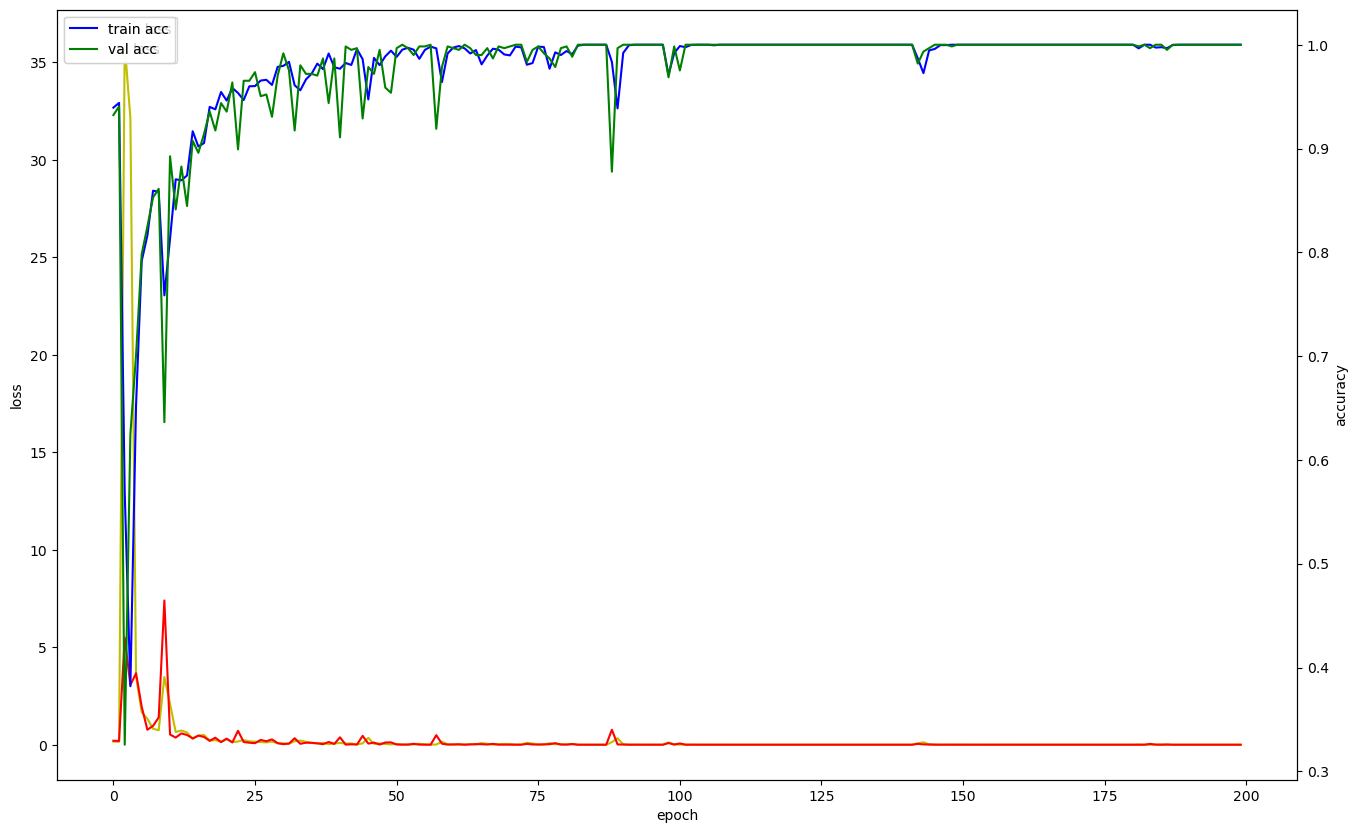

In [17]:
import matplotlib.pyplot as plt

# 그래프 생성
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

# 손실 그래프 설정
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

# 정확도 그래프 설정
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

# 그래프 출력
plt.show()


## 모델 로드 및 검증 데이터 예측

모델 로드: tensorflow.keras.models의 load_model 함수를 사용하여 저장된 모델을 불러옵니다.

모델 예측: 로드된 모델을 사용하여 검증 데이터에 대한 예측을 수행합니다.

검증 데이터: 사전에 분리된 데이터를 사용하여 모델의 일반화 성능을 평가합니다.

## 다중 라벨 혼동 행렬 계산

혼동 행렬: sklearn.metrics의 multilabel_confusion_matrix를 사용하여 다중 라벨 분류 문제의 성능을 평가합니다.

혼동 행렬 계산: 실제 라벨과 예측 라벨을 비교하여 각 클래스에 대한 혼동 행렬을 생성합니다.

결과 해석: 혼동 행렬을 통해 모델이 어떤 클래스에서 잘못된 예측을 했는지 구체적으로 파악할 수 있습니다.

In [18]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

# 저장된 모델 로드
model = load_model('models/model.keras')

# 검증 데이터를 사용하여 모델의 예측 수행
y_pred = model.predict(x_val)

# 다중 라벨 혼동 행렬 계산
confusion_matrices = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

# 다중 라벨 혼동 행렬 출력
confusion_matrices


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([[[515,   0],
        [  0,  90]],

       [[526,   0],
        [  0,  79]],

       [[513,   0],
        [  0,  92]],

       [[517,   0],
        [  0,  88]],

       [[534,   0],
        [  0,  71]],

       [[501,   0],
        [  0, 104]],

       [[524,   0],
        [  0,  81]]], dtype=int64)

## 예외 처리 및 파일 존재 여부 확인   : ppt(X)

예외 처리: 모델 파일이 존재하지 않을 경우를 대비하여 예외 처리를 수행합니다.

파일 확인: os.path.exists를 사용하여 모델 파일의 존재 여부를 확인합니다.

오류 처리: 파일이 존재하지 않을 경우 FileNotFoundError를 발생시켜 사용자에게 알립니다.

전체 흐름: 모델 로드, 예측, 혼동 행렬 계산, 및 예외 처리를 포함한 전체 흐름을 관리합니다.

In [19]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model
import os

# 모델 파일 경로 정의
model_file = 'models/model.keras'

try:
    # 파일 존재 여부 확인
    if os.path.exists(model_file):
        # 모델 로드
        model = load_model(model_file)

        # 검증 데이터에 대한 예측 수행
        y_pred = model.predict(x_val)

        # 다중 라벨 혼동 행렬 계산
        confusion_matrices = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

        # 혼동 행렬 출력
        print(confusion_matrices)
    else:
        raise FileNotFoundError(f"모델 파일 '{model_file}'을 찾을 수 없습니다.")
except Exception as e:
    print("오류가 발생했습니다:", e)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[[[515   0]
  [  0  90]]

 [[526   0]
  [  0  79]]

 [[513   0]
  [  0  92]]

 [[517   0]
  [  0  88]]

 [[534   0]
  [  0  71]]

 [[501   0]
  [  0 104]]

 [[524   0]
  [  0  81]]]
